# Title: Predict_orthologs
### Author: Mathieu Giguere

Brief: Uses machine learning to predict the resistance of FKS1-HS1 Orthologs amino acid sequences to an antifungal drug by training a model on single mutants amino acid sequences. The model uses Expasy Protscale's amino acid properties as features.

Preconditions: Needs Romain Durand's 'nt_refined_classification.csv' from his 'DMS-main' repository and 'aminoAcidProperties.txt'.



In [1]:
# importing modules and packages
import pandas as pd
import numpy as np
np.bool = np.bool_
np.int = np.int_
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, matthews_corrcoef, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import glob
import os

In [2]:
# For SHAP

import shap # v0.39.0
shap.initjs()

## Define the antifungal drug used.

In [3]:
# VIP. Very important parameter. The Antifungal drug.
# Choices are : 'caspofungin', 'anidulafungin', 'micafungin'
drug = 'caspofungin'

# Dictionary to convert 3-level resistance classification to 2-level
parse_res_class = {'deleterious':'sensitive',
                   'slightly deleterious':'sensitive',
                   'WT-like':'sensitive',
                   'intermediary':'resistant',
                   'resistant':'resistant'
                  }

## Specify Output Path

In [4]:
outpath = f'{drug}'

## Make a usable dataframe from the data.

In [5]:
df = pd.read_csv('nt_refined_classification.csv', index_col=0)

#master = df[['compound', 'seq_type', 'Nham_aa', 'aa_seq', 's', 'aa_class']]
#master['resistance'] = np.where(master['aa_class'] == 'WT-like', 'sensitive', 'resistant')
#master = master.drop(columns='aa_class')
#drug_master = master[master['compound'] == drug]

drug_master = df[df.compound == drug][['compound', 'seq_type', 'Nham_aa', 'aa_seq', 's', 'refined_class']]
drug_master['resistance'] = drug_master.refined_class.replace(parse_res_class)
drug_master = drug_master.drop(columns='refined_class').reset_index(drop=True)
drug_master

,compound,seq_type,Nham_aa,aa_seq,s,resistance
0,caspofungin,ortho,1.0,FLILSLRDP,-0.174894,sensitive
1,caspofungin,ortho,1.0,FLTLSLRDP,0.128204,sensitive
2,caspofungin,ortho,2.0,FLALSFRDP,-0.150999,sensitive
3,caspofungin,ortho,2.0,FLALSIRDP,-0.009226,sensitive
4,caspofungin,ortho,2.0,FLSLSFRDP,1.352185,resistant
...,...,...,...,...,...,...
311,caspofungin,single,1.0,TLVLSLRDP,1.331442,resistant
312,caspofungin,single,1.0,TLVLSLRDP,1.924182,resistant
313,caspofungin,single,1.0,VLVLSLRDP,1.884107,resistant
314,caspofungin,single,1.0,WLVLSLRDP,1.399567,resistant


## Import amino acid properties

In [6]:
# Amino acid properties
AAproperties = pd.read_table('aminoAcidProperties.txt')
AAproperties.rename(columns={'Aminoacid.1.letter': 'aa'}, inplace=True)
AAproperties

,aa,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,A,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,...,78,4.34,100,3.9,-0.1,0.5,7.3,0.92,0.38,0.0062
1,C,0.70,0.966,1.11,1.37,1.24,132.3,0.35,14.63,1.19,...,89,35.77,20,-14.3,-2.2,-6.8,-9.2,1.16,-0.30,1.0372
2,D,1.01,0.924,1.04,5.45,0.47,97.8,0.51,10.85,0.54,...,81,12.00,106,-2.8,-2.8,-8.2,-2.9,0.48,-3.27,-0.7485
3,E,1.51,1.504,1.44,6.75,0.62,113.9,0.50,11.89,0.37,...,78,17.26,102,-7.5,-7.5,-16.9,-7.1,0.61,-2.90,-0.7893
4,F,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,...,81,29.40,41,14.7,13.9,13.2,19.2,1.25,1.98,1.2727
5,G,0.57,0.510,0.56,7.07,0.56,62.9,0.54,12.43,0.75,...,84,0.00,49,-2.3,-0.5,0.0,-1.2,0.61,-0.19,-0.1771
6,H,1.00,1.003,1.22,2.27,1.12,155.8,0.32,12.16,0.87,...,84,21.81,66,2.0,0.8,-3.5,-2.1,0.93,-1.44,0.1204
7,I,1.08,1.003,0.97,5.96,1.54,158.0,0.46,15.67,1.60,...,88,19.06,96,11.0,11.8,13.9,6.6,1.81,1.97,1.1109
8,K,1.16,1.172,1.23,5.84,0.74,115.5,0.47,11.36,0.74,...,87,21.29,56,-2.5,-3.2,0.1,-3.7,0.70,-3.46,-1.1806
9,L,1.21,1.236,1.30,9.66,1.26,164.1,0.37,14.90,1.30,...,85,18.78,40,15.0,10.0,8.8,20.0,1.30,1.82,0.9138


## Create training dataframe on single mutants

In [7]:
#Single_master = drug_master.loc[(drug_master['seq_type'] == 'single')]

Single_master = drug_master.loc[drug_master.Nham_aa <=1]

# Explode aa_seq into many columns
Single_master[['aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647']] = Single_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

Single_master


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa639,aa640,aa641,aa642,aa643,aa644,aa645,aa646,aa647
0,caspofungin,ortho,1.0,FLILSLRDP,-0.174894,sensitive,F,L,I,L,S,L,R,D,P
1,caspofungin,ortho,1.0,FLTLSLRDP,0.128204,sensitive,F,L,T,L,S,L,R,D,P
48,caspofungin,single,0.0,FLVLSLRDP,-0.300610,sensitive,F,L,V,L,S,L,R,D,P
49,caspofungin,single,0.0,FLVLSLRDP,0.032684,sensitive,F,L,V,L,S,L,R,D,P
50,caspofungin,single,0.0,FLVLSLRDP,1.043896,resistant,F,L,V,L,S,L,R,D,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,caspofungin,single,1.0,TLVLSLRDP,1.331442,resistant,T,L,V,L,S,L,R,D,P
312,caspofungin,single,1.0,TLVLSLRDP,1.924182,resistant,T,L,V,L,S,L,R,D,P
313,caspofungin,single,1.0,VLVLSLRDP,1.884107,resistant,V,L,V,L,S,L,R,D,P
314,caspofungin,single,1.0,WLVLSLRDP,1.399567,resistant,W,L,V,L,S,L,R,D,P


In [8]:
# Merge dataframe with AAproperties
AA1 = AAproperties.add_suffix('_aa639')
AA1.rename(columns={'aa_aa639': 'aa639'}, inplace=True)
Single_merged = pd.merge(left=Single_master, right=AA1, how='inner', indicator='l639', suffixes=(None, '_aa1'), on='aa639')

for i in range(640,648):
    #print(i)
    AA = AAproperties.add_suffix(f'_aa{i}')
    AA.rename(columns={f'aa_aa{i}': f'aa{i}'}, inplace=True)
    Single_merged = pd.merge(left=Single_merged, right=AA, how='inner', indicator=f'l{i}', suffixes=(None, f'_aa{i}'),
                  on=f'aa{i}')
    
Single_merged

640
641
642
643
644
645
646
647


,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa639,aa640,aa641,aa642,...,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647,l647
0,caspofungin,ortho,1.0,FLILSLRDP,-0.174894,sensitive,F,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,caspofungin,single,1.0,FLILSLRDP,0.093658,sensitive,F,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,caspofungin,ortho,1.0,FLTLSLRDP,0.128204,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,caspofungin,single,1.0,FLTLSLRDP,0.440090,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,caspofungin,single,1.0,FLTLSLRDP,-0.204930,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,caspofungin,single,1.0,FLVLSLRDT,1.895916,resistant,F,L,V,L,...,11.01,97,1.1,1.5,2.7,0.8,1.12,-0.32,0.1031,both
257,caspofungin,single,1.0,FLVLSLRDV,1.841924,resistant,F,L,V,L,...,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599,both
258,caspofungin,single,1.0,FLVLSLRDV,1.791736,resistant,F,L,V,L,...,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599,both
259,caspofungin,single,1.0,FLVLSLRDW,0.081155,sensitive,F,L,V,L,...,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925,both


In [9]:
# Get training data for machine learning.
X_train = Single_merged.drop(columns=['seq_type', 'aa_seq', 'compound', 's', 'Nham_aa', 'resistance',
                                      'l639', 'l640', 'l641', 'l642', 'l643', 'l644', 'l645', 'l646', 'l647',
                                      'aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647'])

X_train

,alpha_helix_chou_aa639,alpha_helix_deleage_aa639,alpha_helix_levitt_aa639,aminoacid_composition_swissprot_bairoch_aa639,antiparallel_beta_strand_lifson_aa639,average_area_buried_folding_rose_aa639,average_flexibility_bhaskaran_aa639,average_surrounding_hydrophobicity_manavalan_aa639,beta_sheet_chou_aa639,beta_sheet_deleage_aa639,...,recognition_factors_aa647,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,93,11.01,97,1.1,1.5,2.7,0.8,1.12,-0.32,0.1031
257,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,89,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599
258,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,89,13.92,74,2.1,3.3,2.7,3.5,1.81,1.46,0.7599
259,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.0,1.38,1.393,...,104,42.53,18,17.8,18.1,14.9,16.3,1.54,1.53,0.7925


In [10]:
y_train = Single_merged['resistance']

y_train

0      sensitive
1      sensitive
2      sensitive
3      sensitive
4      sensitive
         ...    
256    resistant
257    resistant
258    resistant
259    sensitive
260    resistant
Name: resistance, Length: 261, dtype: object

## Create Orthologs Prediction (test) dataframe

In [12]:
Ortholog_master = drug_master.loc[drug_master.Nham_aa > 1]

# Explode aa_seq into many columns
Ortholog_master[['aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647']] = Ortholog_master['aa_seq'].apply(lambda x: pd.Series(list(x)))

Ortholog_master


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa639,aa640,aa641,aa642,aa643,aa644,aa645,aa646,aa647
2,caspofungin,ortho,2.0,FLALSFRDP,-0.150999,sensitive,F,L,A,L,S,F,R,D,P
3,caspofungin,ortho,2.0,FLALSIRDP,-0.009226,sensitive,F,L,A,L,S,I,R,D,P
4,caspofungin,ortho,2.0,FLSLSFRDP,1.352185,resistant,F,L,S,L,S,F,R,D,P
5,caspofungin,ortho,2.0,FLTLSFRDP,0.194558,sensitive,F,L,T,L,S,F,R,D,P
6,caspofungin,ortho,2.0,FLTLSIRDP,0.112074,sensitive,F,L,T,L,S,I,R,D,P
7,caspofungin,ortho,2.0,FLTLSLKDP,-0.069431,sensitive,F,L,T,L,S,L,K,D,P
8,caspofungin,ortho,2.0,FLTLSLRDA,1.771898,resistant,F,L,T,L,S,L,R,D,A
9,caspofungin,ortho,2.0,FLTLSLVDP,-0.391748,sensitive,F,L,T,L,S,L,V,D,P
10,caspofungin,ortho,2.0,FLTLSVRDP,0.029610,sensitive,F,L,T,L,S,V,R,D,P
11,caspofungin,ortho,2.0,FMALSLRDP,0.173952,sensitive,F,M,A,L,S,L,R,D,P


In [18]:
# Merge dataframe with AAproperties
#AA1 = AAproperties.add_suffix('_aa639')
#AA1.rename(columns={'aa_aa639': 'aa639'}, inplace=True)
Ortholog_merged = pd.merge(left=Ortholog_master, right=AA1, how='inner', indicator='l639', suffixes=(None, '_aa1'), on='aa639')


for i in range(640,648):
    #print(i)
    AA = AAproperties.add_suffix(f'_aa{i}')
    AA.rename(columns={f'aa_aa{i}': f'aa{i}'}, inplace=True)
    Ortholog_merged = pd.merge(left=Ortholog_merged, right=AA, how='inner', indicator=f'l{i}', suffixes=(None, f'_aa{i}'),
                  on=f'aa{i}')

Ortholog_merged

,compound,seq_type,Nham_aa,aa_seq,s,resistance,aa639,aa640,aa641,aa642,...,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647,l647
0,caspofungin,ortho,2.0,FLALSFRDP,-0.150999,sensitive,F,L,A,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
1,caspofungin,ortho,3.0,YLALSFRDP,1.929665,resistant,Y,L,A,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
2,caspofungin,ortho,2.0,FLSLSFRDP,1.352185,resistant,F,L,S,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
3,caspofungin,ortho,2.0,FLTLSFRDP,0.194558,sensitive,F,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
4,caspofungin,ortho,3.0,YLTLSFRDP,1.930501,resistant,Y,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
5,caspofungin,ortho,3.0,ALTLSFRDP,1.990216,resistant,A,L,T,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
6,caspofungin,ortho,3.0,YLILSFRDP,1.959712,resistant,Y,L,I,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
7,caspofungin,ortho,3.0,FLTHSFRDP,1.953348,resistant,F,L,T,H,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
8,caspofungin,ortho,4.0,YLTRSFRDP,2.006457,resistant,Y,L,T,R,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both
9,caspofungin,ortho,2.0,FLALSIRDP,-0.009226,sensitive,F,L,A,L,...,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799,both


In [19]:
# Get testing data for machine learning.
X_test = Ortholog_merged.drop(columns=['seq_type', 'aa_seq', 'compound', 's', 'Nham_aa', 'resistance',
                                    'l639', 'l640', 'l641', 'l642', 'l643', 'l644', 'l645', 'l646', 'l647',
                                    'aa639', 'aa640', 'aa641', 'aa642', 'aa643', 'aa644', 'aa645', 'aa646', 'aa647'])

X_test

,alpha_helix_chou_aa639,alpha_helix_deleage_aa639,alpha_helix_levitt_aa639,aminoacid_composition_swissprot_bairoch_aa639,antiparallel_beta_strand_lifson_aa639,average_area_buried_folding_rose_aa639,average_flexibility_bhaskaran_aa639,average_surrounding_hydrophobicity_manavalan_aa639,beta_sheet_chou_aa639,beta_sheet_deleage_aa639,...,recognition_factors_aa647,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647
0,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
1,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
4,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
5,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,0.709,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
6,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
7,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
8,0.69,0.787,0.72,2.92,1.68,177.7,0.42,13.42,1.47,1.266,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
9,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799


In [20]:
y_test = Ortholog_merged['resistance']

y_test

0     sensitive
1     resistant
2     resistant
3     sensitive
4     resistant
5     resistant
6     resistant
7     resistant
8     resistant
9     sensitive
10    sensitive
11    resistant
12    resistant
13    sensitive
14    resistant
15    resistant
16    sensitive
17    sensitive
18    resistant
19    sensitive
20    resistant
21    sensitive
22    resistant
23    resistant
24    sensitive
25    sensitive
26    resistant
27    sensitive
28    sensitive
29    resistant
30    resistant
31    resistant
32    resistant
33    resistant
34    resistant
35    resistant
36    sensitive
37    resistant
38    resistant
39    resistant
40    resistant
41    resistant
42    resistant
43    resistant
44    resistant
45    resistant
Name: resistance, dtype: object

## Machine Learning

In [21]:
# Use Gridsearch & Random Forest

print(drug)

if drug == 'caspofungin' :
    grid = {'n_estimators': [100],
            'max_features': [9, 14, 15, 17, 23, 25],
            'max_depth': [10,12,15,20,23,25],
            'min_samples_split': [2],
            'min_samples_leaf' : [1],
            'random_state': [18]}

elif drug == 'anidulafungin' :
    grid = {'n_estimators': [100],
            'max_features': [9, 13, 17, 23, 25],
            'max_depth': [10, 12, 15, 17,20],
            'min_samples_split': [2],
            'min_samples_leaf' : [1],
            'random_state': [18]}

elif drug == 'micafungin' :
    grid = {'n_estimators': [100],
            'max_features': [15,17,19,20,21,23],
            'max_depth': [7,8,10,12,13,14],
            'min_samples_split': [2],
            'min_samples_leaf' : [1],
            'random_state': [18]}

else:
    print("Wrong drug")


CV_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, n_jobs=-1, cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=18), scoring='balanced_accuracy')
CV_rf.fit(X_train, y_train)
print(CV_rf.best_params_)

y_pred = CV_rf.predict(X_test)

caspofungin
{'max_depth': 20, 'max_features': 23, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 18}


In [22]:
# See splits

CVdf = pd.DataFrame(data=CV_rf.cv_results_)

CVdf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.193279,0.003977,0.018256,0.000942,10,9,1,2,100,18,"{'max_depth': 10, 'max_features': 9, 'min_samp...",0.764368,0.887302,0.774242,0.868939,0.816810,0.822332,0.049186,36
1,0.198884,0.006588,0.017453,0.000806,10,14,1,2,100,18,"{'max_depth': 10, 'max_features': 14, 'min_sam...",0.857759,0.873016,0.793939,0.868939,0.799569,0.838644,0.034612,33
2,0.194723,0.002960,0.016957,0.000303,10,15,1,2,100,18,"{'max_depth': 10, 'max_features': 15, 'min_sam...",0.816092,0.887302,0.778788,0.859091,0.834052,0.835065,0.036970,34
3,0.195320,0.001559,0.019785,0.003114,10,17,1,2,100,18,"{'max_depth': 10, 'max_features': 17, 'min_sam...",0.836925,0.873016,0.793939,0.884091,0.834052,0.844405,0.031948,31
4,0.252942,0.047405,0.019165,0.001976,10,23,1,2,100,18,"{'max_depth': 10, 'max_features': 23, 'min_sam...",0.785201,0.915079,0.819697,0.884091,0.837644,0.848342,0.046160,30
5,0.224067,0.016927,0.017062,0.000422,10,25,1,2,100,18,"{'max_depth': 10, 'max_features': 25, 'min_sam...",0.840517,0.845238,0.789394,0.834091,0.854885,0.832825,0.022750,35
6,0.203136,0.015806,0.017021,0.000362,12,9,1,2,100,18,"{'max_depth': 12, 'max_features': 9, 'min_samp...",0.806034,0.915079,0.809091,0.853788,0.837644,0.844327,0.039618,32
7,0.195607,0.001628,0.017010,0.000367,12,14,1,2,100,18,"{'max_depth': 12, 'max_features': 14, 'min_sam...",0.857759,0.900794,0.864394,0.909091,0.816810,0.869769,0.033126,23
8,0.196271,0.000140,0.016914,0.000415,12,15,1,2,100,18,"{'max_depth': 12, 'max_features': 15, 'min_sam...",0.836925,0.887302,0.809091,0.924242,0.834052,0.858322,0.041607,29
9,0.200904,0.006061,0.016546,0.000252,12,17,1,2,100,18,"{'max_depth': 12, 'max_features': 17, 'min_sam...",0.836925,0.887302,0.864394,0.909091,0.834052,0.866353,0.028909,26


In [23]:
y_pred_train = CV_rf.predict(X_train)
    
bal_acc_train = balanced_accuracy_score(y_train, y_pred_train)
print(bal_acc_train)

bal_acc_test = balanced_accuracy_score(y_test, y_pred)
print(bal_acc_test)

0.9663919413919414
0.9486607142857143


In [24]:
export_df = pd.DataFrame(data=[y_test,y_pred])
export_df = export_df.T
export_df.rename(columns={'resistance': 'y_test'}, inplace=True)
export_df.rename(columns={'Unnamed 0': 'y_pred'}, inplace=True)

export_df.to_csv(f'{outpath}/{drug}_ML_orthologs_results.csv', index=False)

export_df

,y_test,y_pred
0,sensitive,sensitive
1,resistant,resistant
2,resistant,sensitive
3,sensitive,sensitive
4,resistant,resistant
5,resistant,resistant
6,resistant,resistant
7,resistant,resistant
8,resistant,resistant
9,sensitive,sensitive


In [25]:
proba = CV_rf.predict_proba(X_test)[::,1]

proba_df = pd.DataFrame(data=proba)
proba_df.to_csv(f'{outpath}/{drug}_ML_ROCproba.csv', index=False)

# End of code.

## SHAP values

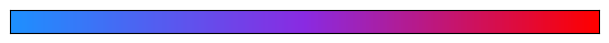

['beta_sheet_levitt_aa644', 'levy_propensity_aa639', 'beta_sheet_deleage_aa641', 'hydrophobicity_miyazawa_aa639', 'hydrophobicity_chothia_aa644']


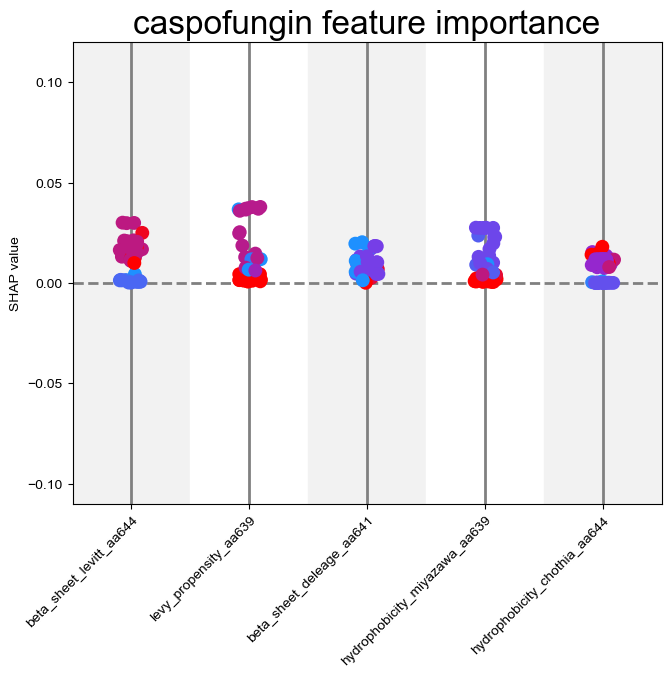

In [26]:
## Most important Features (mif)
#shap_explainer = shap.TreeExplainer(CV_rf.best_estimator_)
#shap_values = shap_explainer.shap_values(X_test)
#vals = np.abs(shap_values).mean(0)
#feature_importance = pd.DataFrame(list(zip(X_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
#feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
#mif = feature_importance[0:5]['col_name'].to_list()
#print(mif)

from matplotlib.colors import LinearSegmentedColormap
import shap
## Re-compute SHAP values
# Create SHAP explainer for the trained model (brf) and calculate SHAP values for the test data (X_test_s)
explainer = shap.Explainer(CV_rf.best_estimator_)
shap_v = explainer(X_test)

## Extract SHAP values and reshape df
# Create DataFrames for SHAP values and original data
shap_df = pd.DataFrame(shap_v.values[:,:,0])
data = pd.DataFrame(shap_v.data)
columns = X_test.columns
shap_df.columns = columns
data.columns = columns

# Function to normalize a column to the range [0, 1]
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    if min_val == max_val:
        return column
    else:
        return (column - min_val) / (max_val - min_val)

# Apply min-max scaling to each column in the original data DataFrame
data = data.apply(min_max_scaling)
# Reshape SHAP values DataFrame and original data DataFrame for plotting
shap_long = shap_df.melt(var_name='Features', value_name='Shap values')
data_long = data.melt(var_name='Features', value_name='Data')
# Concatenate SHAP values and original data for plotting
df = pd.concat([shap_long, data_long['Data']], axis=1)

### Custom plot
# Define a custom color map for the beeswarm plot
colors = [(0.0, 'dodgerblue'), (0.5, 'blueviolet'), (1.0, 'red')]
cmap_name = "shap_beeswarm"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
# Plot a color gradient to visualize the custom color map
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(figsize=(7.6, 0.3))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(gradient, aspect="auto", cmap=custom_cmap)
plt.show()

# Select specific columns for the final strip plot. Using the most important features. Most important Features (mif)
fi = df
fi['Shap values'] = fi['Shap values'].abs()
feature_importance = fi.groupby(['Features'], as_index=False).mean()
feature_importance.sort_values(by=['Shap values'], ascending=False,inplace=True)
mif = feature_importance[0:5]['Features'].to_list()
print(mif)

# Create a strip plot for selected columns using SHAP values and original data
fig, ax = plt.subplots(figsize=(7.6, 6))
sns.set(font_scale=2)

sns.stripplot(data=df[df['Features'].isin(mif)], x='Features', y='Shap values', hue='Data',
              legend=False, jitter=True, palette=custom_cmap, size=10, order=mif)

ax.set_ylim(-0.11, 0.12)
plt.xlabel('')
plt.ylabel('SHAP value')

plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
ax.grid(axis='x', linewidth=2, color='gray')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=2)
ax.yaxis.grid(False)

# Get unique categories from the X-axis variable
categories = df["Features"].unique()

# Set the colors for alternating background regions
background_colors = ['#F2F2F2', 'white']

# Iterate through categories and add alternating background patches
for i, cat in enumerate(categories):
    color = background_colors[i % 2]
    x_values = df[df['Features'] == cat]['Features'].values
    x_range = (i - 0.5, i + 0.5)
    y_range = ax.get_ylim()
    ax.add_patch(plt.Rectangle((x_range[0], y_range[0]), x_range[1] - x_range[0], y_range[1] - y_range[0], color=color, zorder=-1))

plt.gca().set_title(f'{drug} feature importance', fontsize=24)    
plt.show()